<a href="https://colab.research.google.com/github/romanzes637/tensor/blob/master/clust.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [90]:
import numpy as np

paths = ['/gdrive/My Drive/Colab Notebooks/tube10El/{}/devStr'.format(x) for x in range(1, 35)]
times = list()
ts= list()
# for i, p in enumerate([paths[0], paths[3], paths[7], paths[10]]):
# initial state
m = 4000
n = 100
ts.append(np.zeros((n, 6)))
times.append(np.full(n, 0))
for i, p in enumerate(paths):
  with open(p) as f:
    lines = f.readlines()
    x = np.array([[float(y) for y in x.strip()[1:-1].split()] for x in lines[18:-5]])[m:m+n]
    ts.append(x)
    times.append(np.full(len(x), i + 1))
ts = np.vstack(ts)
color = np.hstack(times)
print(len(ts), ts[0], ts[-1])
print(len(color), color[0], color[-1])

3500 [0. 0. 0. 0. 0. 0.] [-3.59182e+07  7.25528e+07 -1.48780e-01  2.41899e+06 -1.43984e+00
  3.34992e+07]
3500 0 34


In [0]:
def tensor_sort(t):
  at_map = {
      (1, 2): 3, (2, 1): 3,
      (0, 2): 4, (2, 0): 4,
      (0, 1): 5, (1, 0): 5
  }
  st = t[:3]
  sort_st = np.argsort(-np.abs(st))
  ind = np.array([sort_st[0], 
                  sort_st[1], 
                  sort_st[2], 
                  at_map[(sort_st[0], sort_st[1])],
                  at_map[(sort_st[1], sort_st[2])],
                  at_map[(sort_st[2], sort_st[0])]])
  new_t = t[ind]
  return new_t
def tensors_stat(ts):
  stat = dict()
  for t in ts:
    tt = tuple(t)
    stat[tt] = stat.get(tt, 0) + 1
  return stat
# t = np.array([1, 2, -3, 2, 0, 1])
# tensor_sort(t)
# ts = np.array([
#     [1, 2, -3, 2, 0, 1],
#     [1, 2, -3, 2, 0, 1]
# ])
# print(ts)
# ts = np.apply_along_axis(tensor_sort, 1, ts)
# print(ts)

In [92]:
# Sort tensors (max, int, min, max-int, int-min, min-max)
print(ts[-1])
ts = np.apply_along_axis(tensor_sort, 1, ts)
print(ts[-1])
X = ts
print(len(X))
print(X[-1])
# Normalize to interval [-1, 1]
X = np.apply_along_axis(
    lambda x: x / max(np.abs(x)) if max(np.abs(x)) != 0 else x, 1, X)
print(X[-1])
# Normalize to distinct: -1, 0 and 1, 0.5, -0.5
X2 = np.copy(X)
X2[(X2 > -1e-3) & (X2 < 1e-3)] = 0
X2[(X2 > 0) & (X2 <= 0.5)] = 0.5
X2[(X2 < 0) & (X2 >= -0.5)] = -0.5
X2[(X2 > 0.5)] = 1
X2[(X2 < -0.5)] = -1
# X2[X2 > 0] = 1
# X2[X2 < 0] = -1
# X = X2
# Colors
print(color[-1])
color = color / max(color)
print(color[-1])

[-3.59182e+07  7.25528e+07 -1.48780e-01  2.41899e+06 -1.43984e+00
  3.34992e+07]
[ 7.25528e+07 -3.59182e+07 -1.48780e-01  3.34992e+07 -1.43984e+00
  2.41899e+06]
3500
[ 7.25528e+07 -3.59182e+07 -1.48780e-01  3.34992e+07 -1.43984e+00
  2.41899e+06]
[ 1.00000000e+00 -4.95062906e-01 -2.05064450e-09  4.61721670e-01
 -1.98454091e-08  3.33410978e-02]
34
1.0


[t-SNE] Computing 1501 nearest neighbors...
[t-SNE] Indexed 3500 samples in 0.014s...
[t-SNE] Computed neighbors for 3500 samples in 1.172s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3500
[t-SNE] Computed conditional probabilities for sample 2000 / 3500
[t-SNE] Computed conditional probabilities for sample 3000 / 3500
[t-SNE] Computed conditional probabilities for sample 3500 / 3500
[t-SNE] Mean sigma: 0.075792
[t-SNE] KL divergence after 250 iterations with early exaggeration: 41.361549
[t-SNE] KL divergence after 1000 iterations: 0.047913
t-SNE: 99 sec
(3500, 2)


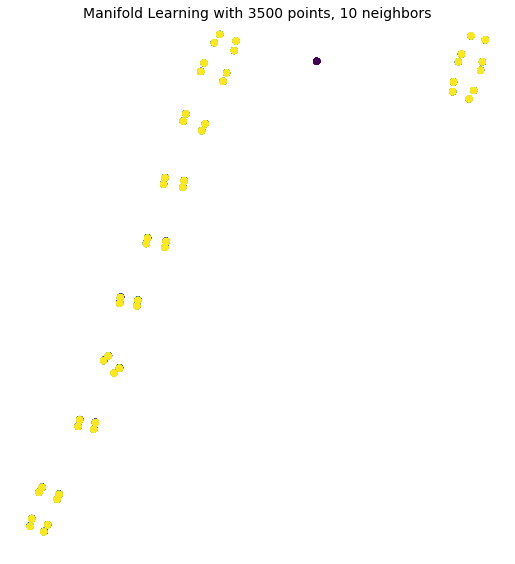

In [94]:
from time import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from sklearn import manifold, datasets, preprocessing

# Next line to silence pyflakes. This import is needed.
Axes3D  

fig = plt.figure(figsize=(8, 8))
update = True
if update:  # rate is about of 10000 points/sec
  n_points = len(X)
  n_neighbors = 10
  n_components = 2
  plt.suptitle("Manifold Learning with %i points, %i neighbors"
               % (n_points, n_neighbors), fontsize=14)
  # ax = fig.add_subplot(251, projection='3d')
  # ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
  # ax.view_init(4, -72)

  methods = ['standard', 'ltsa', 'hessian', 'modified']
  labels = ['LLE', 'LTSA', 'Hessian LLE', 'Modified LLE']

  # for i, method in enumerate(methods):
  #     t0 = time()
  #     Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components,
  #                                         eigen_solver='auto',
  #                                         method=method).fit_transform(X)
  #     t1 = time()
  #     print("%s: %.2g sec" % (methods[i], t1 - t0))

  #     ax = fig.add_subplot(252 + i)
  #     plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
  #     plt.title("%s (%.2g sec)" % (labels[i], t1 - t0))
  #     ax.xaxis.set_major_formatter(NullFormatter())
  #     ax.yaxis.set_major_formatter(NullFormatter())
  #     plt.axis('tight')


  # t0 = time()
  # Y1 = manifold.Isomap(n_neighbors, n_components).fit_transform(X)
  # t1 = time()
  # print("Isomap: %.2g sec" % (t1 - t0))
  # ax = fig.add_subplot(257)
  # plt.scatter(Y1[:, 0], Y1[:, 1], c=color, cmap=plt.cm.Spectral)
  # plt.title("Isomap (%.2g sec)" % (t1 - t0))
  # ax.xaxis.set_major_formatter(NullFormatter())
  # ax.yaxis.set_major_formatter(NullFormatter())
  # plt.axis('tight')


  # t0 = time()
  # mds = manifold.MDS(n_components, max_iter=100, n_init=1)
  # Y2 = mds.fit_transform(X)
  # t1 = time()
  # print("MDS: %.2g sec" % (t1 - t0))
  # ax = fig.add_subplot(258)
  # plt.scatter(Y2[:, 0], Y2[:, 1], c=color, cmap=plt.cm.Spectral)
  # plt.title("MDS (%.2g sec)" % (t1 - t0))
  # ax.xaxis.set_major_formatter(NullFormatter())
  # ax.yaxis.set_major_formatter(NullFormatter())
  # plt.axis('tight')


  # t0 = time()
  # se = manifold.SpectralEmbedding(n_components=n_components,
  #                                 n_neighbors=n_neighbors)
  # Y3 = se.fit_transform(X)
  # t1 = time()
  # print("SpectralEmbedding: %.2g sec" % (t1 - t0))
  # ax = fig.add_subplot(259)
  # plt.scatter(Y3[:, 0], Y3[:, 1], c=color, cmap=plt.cm.Spectral)
  # plt.title("SpectralEmbedding (%.2g sec)" % (t1 - t0))
  # ax.xaxis.set_major_formatter(NullFormatter())
  # ax.yaxis.set_major_formatter(NullFormatter())
  # plt.axis('tight')

  t0 = time()
  tsne = manifold.TSNE(n_components=n_components, 
                       perplexity=500,
                       early_exaggeration=12.0,
                       learning_rate=200.,
                       init='random',
                       n_iter=1000,
                       verbose=1,
                       method='barnes_hut',
                       random_state=None)
  Y4 = tsne.fit_transform(X)
  t1 = time()
  print("t-SNE: %.2g sec" % (t1 - t0))
  # plt.title("t-SNE (%.2g sec)" % (t1 - t0))
  np.save('/gdrive/My Drive/Colab Notebooks/Y4_test', Y4)
else:
  print('loading')
  Y4 = np.load('/gdrive/My Drive/Colab Notebooks/Y4_test.npy')
print(Y4.shape)
# ax = fig.add_subplot(2, 5, 10)
ax = fig.add_subplot(1, 1, 1)
plt.scatter(Y4[:, 0], Y4[:, 1], c=color, cmap=plt.cm.viridis)
# start = 30000
# end = 35001
# plt.scatter(Y4[start:end, 0], Y4[start:end, 1], c=color[start:end], cmap=plt.cm.viridis)
# ax.set_facecolor('black')
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
ax.set_aspect('equal')
plt.tight_layout()
plt.axis('off')
plt.show()

In [0]:
import pandas as pd

# data = np.array([
#     [6, 1],
#     [7, 2],
#     [8., 3],
#     [9, 4],
#     [0, 5.],
#     [3, 6],
#     [6, 7]
# ])
# times = np.array([3, 3, 3, 2, 2, 7, 2])
# kinds = ['a', 'b', 'a', 'b', 'c', 'd', 'a']
start_step = 0
end_step = 35
n = 100
data = Y4[start_step*n:(end_step + 1)*n]
times = color[start_step*n:(end_step + 1)*n]
kinds = [' | '.join(map(str, x)) for x in X2[start_step*n:(end_step + 1)*n]]
tensors = [' | '.join(map("{:.2f}".format, x)) for x in X[start_step*n:(end_step + 1)*n]]
df = pd.DataFrame({'x': data[:, 0], 'y': data[:, 1], 'time': times, 
                   'kind': kinds, 'tensor': tensors})

In [99]:
import altair as alt
alt.data_transformers.enable(max_rows=None)
interval = alt.selection_interval(
  zoom=False,
  on='[mousedown[event.button === 0], window:mouseup] > window:mousemove!'
)
scale = alt.selection_interval(
  bind='scales', 
  translate='[mousedown[event.button === 1], window:mouseup] > window:mousemove!')
size = 300
# input_checkbox = alt.binding_checkbox()
# checkbox_selection = alt.selection_single(bind=input_checkbox, name="Big Budget Films")
checkbox_condition = alt.condition(
    checkbox_selection,
    alt.SizeValue(25),
    alt.Size('Hundred_Million_Production:Q')
   )

points = alt.Chart(df, width=size, height=size).mark_point().encode(
  alt.X('x:Q', axis=alt.Axis(title='', grid=False)),
  alt.Y('y:Q', axis=alt.Axis(title='', grid=False)),
  color=alt.condition(interval, 'kind', alt.value('lightgray')),
  tooltip='tensor:N'
#   size=alt.value(10)
).add_selection(
#     checkbox_selection,
    interval,
    scale
)

histogram = alt.Chart(df, width=size).mark_bar().encode(
  alt.X('count()', axis=alt.Axis(title='', grid=False)),
  alt.Y('kind', axis=alt.Axis(title='', grid=False)),
  color=alt.Color('kind:N', scale=alt.Scale(scheme='tableau10'))
).transform_filter(interval)

# ch = points
ch = points & histogram
ch.save('/gdrive/My Drive/Colab Notebooks/ch.html')
ch

VConcatChart({
  data:               x  ...                                       tensor
  0      8.137244  ...      0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00
  1      8.137244  ...      0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00
  2      8.137244  ...      0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00
  3      8.137244  ...      0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00
  4      8.137244  ...      0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00
  5      8.137244  ...      0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00
  6      8.137244  ...      0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00
  7      8.137244  ...      0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00
  8      8.137244  ...      0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00
  9      8.137244  ...      0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00
  10     8.137244  ...      0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00
  11     8.137244  ...      0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00
  12     8.137244  ...      0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00
  13     8.137244  ...      0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00
  14     8.137244  ...      0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00
  15     8.137244  ...      0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00
  16     8.137244  ...      0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00
  17     8.137244  ...      0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00
  18     8.137244  ...      0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00
  19     8.137244  ...      0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00
  20     8.137244  ...      0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00
  21     8.137244  ...      0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00
  22     8.137244  ...      0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00
  23     8.137244  ...      0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00
  24     8.137244  ...      0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00
  25     8.137244  ...      0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00
  26     8.137244  ...      0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00
  27     8.137244  ...      0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00
  28     8.137244  ...      0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00
  29     8.137244  ...      0.00 | 0.00 | 0.00 | 0.00 | 0.00 | 0.00
  ...         ...  ...                                          ...
  3470  -9.194383  ...   1.00 | -0.60 | 0.00 | 0.99 | -0.00 | -0.39
  3471  -9.194383  ...   1.00 | -0.60 | 0.00 | 0.99 | -0.00 | -0.39
  3472  -9.845246  ...   0.91 | -0.59 | 0.00 | 1.00 | -0.00 | -0.41
  3473  -9.948022  ...   0.90 | -0.59 | 0.00 | 1.00 | -0.00 | -0.41
  3474  -9.948022  ...   0.90 | -0.59 | 0.00 | 1.00 | -0.00 | -0.41
  3475  -9.845246  ...   0.91 | -0.59 | 0.00 | 1.00 | -0.00 | -0.41
  3476  -8.847159  ...   0.91 | -0.55 | 0.00 | 1.00 | -0.00 | -0.45
  3477  -9.084083  ...   0.90 | -0.55 | 0.00 | 1.00 | -0.00 | -0.45
  3478  -9.084083  ...   0.90 | -0.55 | 0.00 | 1.00 | -0.00 | -0.45
  3479  -8.847159  ...   0.91 | -0.55 | 0.00 | 1.00 | -0.00 | -0.45
  3480  17.737612  ...    1.00 | -0.37 | 0.00 | 0.32 | -0.00 | 0.06
  3481  17.737612  ...    1.00 | -0.37 | 0.00 | 0.32 | -0.00 | 0.06
  3482  16.702427  ...    1.00 | -0.42 | 0.00 | 0.32 | -0.00 | 0.10
  3483  16.702427  ...    1.00 | -0.42 | 0.00 | 0.32 | -0.00 | 0.10
  3484  18.035053  ...    1.00 | -0.38 | 0.00 | 0.34 | -0.00 | 0.05
  3485  18.035053  ...    1.00 | -0.38 | 0.00 | 0.34 | -0.00 | 0.05
  3486  16.759491  ...   1.00 | -0.43 | -0.00 | 0.34 | -0.00 | 0.09
  3487  16.759491  ...    1.00 | -0.43 | 0.00 | 0.34 | -0.00 | 0.09
  3488  18.464088  ...   1.00 | -0.41 | -0.00 | 0.38 | -0.00 | 0.02
  3489  18.464088  ...   1.00 | -0.41 | -0.00 | 0.38 | -0.00 | 0.02
  3490  17.067333  ...    1.00 | -0.46 | 0.00 | 0.39 | -0.00 | 0.07
  3491  17.067333  ...    1.00 | -0.46 | 0.00 | 0.39 | -0.00 | 0.07
  3492  18.574095  ...    1.00 | -0.42 | 0.00 | 0.40 | -0.00 | 0.02
  3493  18.574095  ...    1.00 | -0.42 | 0.00 | 0.40 | -0.00 | 0.02
  3494  17.258127  ...    1.00 | -0.47 | 0.00 | 0.40 | -0.00 | 0.06
  3495  17.258127  ...    1.00 | -0.47 | 0.00 | 0.40 | -0.00 | 0.06
  3496  18.757742  ...  1.00 | -0.4

MovieWriter imagemagick unavailable. Trying to use pillow instead.


16000 5 0 1 0 16000 16000 32000 0.0
16000 5 0 1 0 16000 16000 32000 0.0
16000 5 0 1 0 16000 16000 32000 0.2
16000 5 0 1 0 16000 16000 32000 0.4
16000 5 0 1 0 16000 16000 32000 0.6
16000 5 0 1 0 16000 16000 32000 0.8
16000 5 1 2 16000 32000 32000 48000 0.0
16000 5 1 2 16000 32000 32000 48000 0.19999999999999996
16000 5 1 2 16000 32000 32000 48000 0.3999999999999999
16000 5 1 2 16000 32000 32000 48000 0.6000000000000001
16000 5 1 2 16000 32000 32000 48000 0.8
16000 5 2 3 32000 48000 48000 64000 0.0
16000 5 2 3 32000 48000 48000 64000 0.20000000000000018
16000 5 2 3 32000 48000 48000 64000 0.3999999999999999
16000 5 2 3 32000 48000 48000 64000 0.6000000000000001
16000 5 2 3 32000 48000 48000 64000 0.7999999999999998
16000 5 3 4 48000 64000 64000 80000 0.0
16000 5 3 4 48000 64000 64000 80000 0.20000000000000018
16000 5 3 4 48000 64000 64000 80000 0.3999999999999999
16000 5 3 4 48000 64000 64000 80000 0.6000000000000001
16000 5 3 4 48000 64000 64000 80000 0.7999999999999998
16000 5 4 5 6400

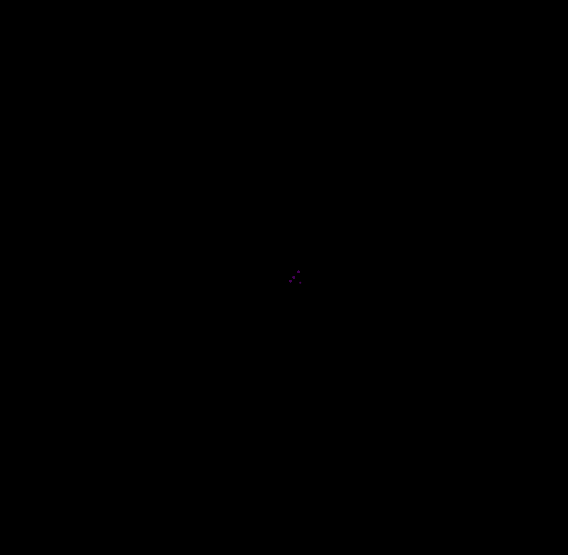

In [7]:
import matplotlib.pyplot as plt
from matplotlib import animation, style, cm
style.use('dark_background')
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
cmap = cm.get_cmap('viridis')
colors = cmap(color)
def draw_3d_update(frame, m, n):
  d = 3
  i = int(frame / m)
  k = frame / m - i
  prev_start = i * n
  prev_end = i * n + n
  start = (i + 1) * n
  end = (i + 1) * n + n
  if end > len(Y4):
    start = prev_start
    end = prev_end
  print(n, m, i, i + 1, prev_start, prev_end, start, end, k)
  cs = colors[start:end]
  ps = Y4[start:end]
  prev_ps = Y4[prev_start:prev_end]
  prev_cs = colors[prev_start:prev_end]
  delta_ps = ps - prev_ps
  delta_cs = cs - prev_cs
  cur_ps = prev_ps + k * delta_ps
  cur_cs = prev_cs + k * delta_cs
  ax.cla()
  ax.scatter(cur_ps[:, 0], cur_ps[:, 1], s=1**2, c=cur_cs)
  ax.set_xlim(min(Y4[:, 0]) - d, max(Y4[:, 0]) + d)
  ax.set_ylim(min(Y4[:, 1]) - d, max(Y4[:, 1]) + d)
#   ax.set_xlim(-6.5, -2)
#   ax.set_ylim(1, 5.5)
# ax.xaxis.set_major_formatter(NullFormatter())
# ax.yaxis.set_major_formatter(NullFormatter())
  ax.set_aspect('equal')
  plt.axis('off')
  plt.tight_layout()
steps = 35
m = 5
n = 16000
ani = animation.FuncAnimation(fig, draw_3d_update, (steps - 1)*m + 1, 
                              fargs=[m, n], interval=200, blit=False)
ani.save('/gdrive/My Drive/Colab Notebooks/test2.gif', writer='imagemagick')

/usr/local/lib/python3.6/dist-packages/sklearn/cluster/optics_.py:795: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


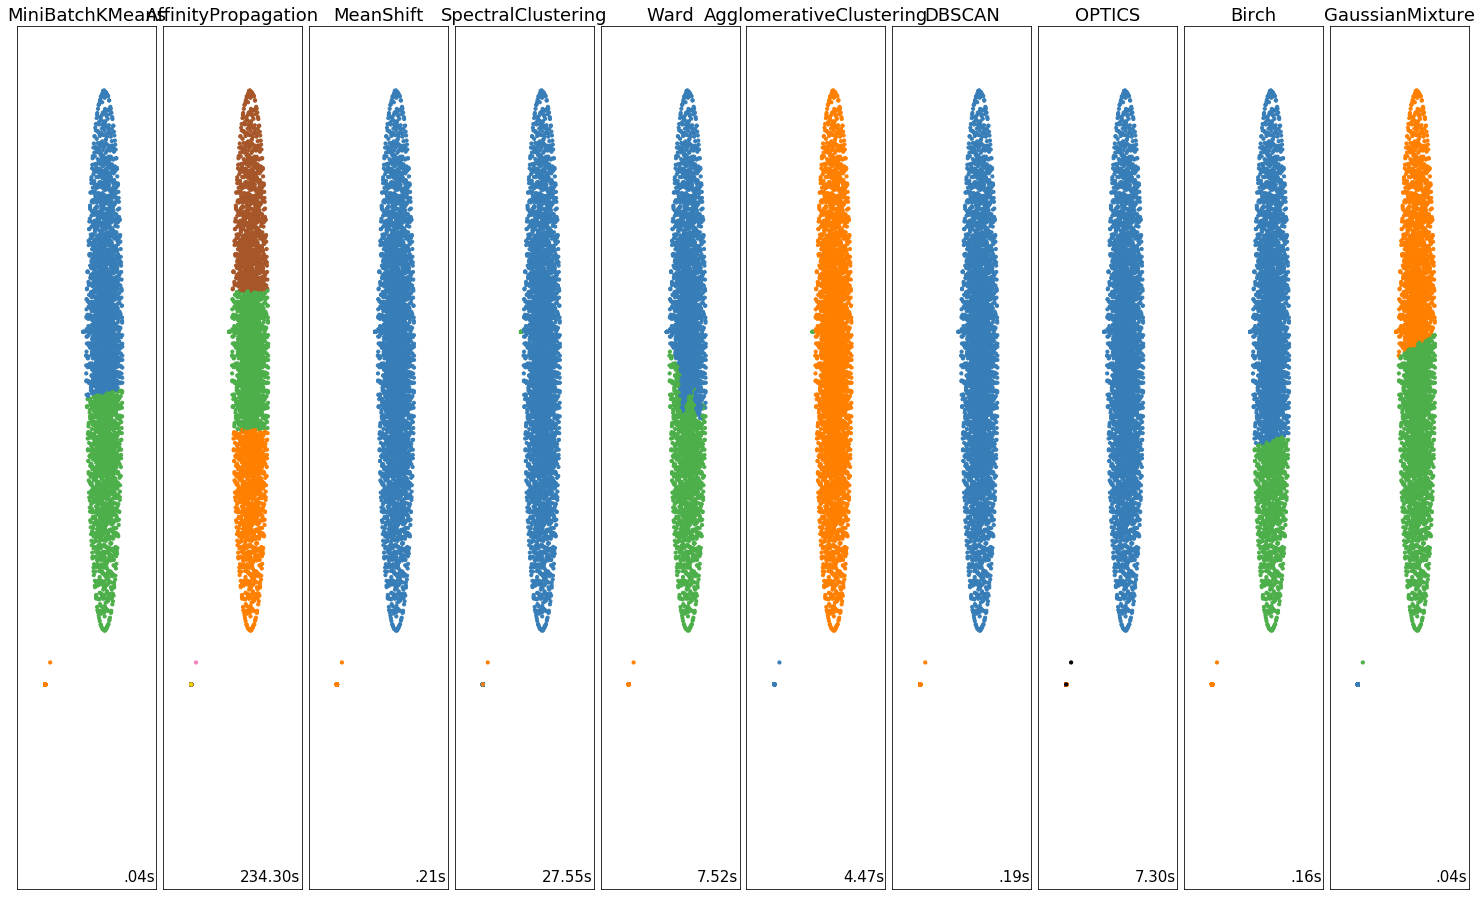

In [104]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}

# datasets = [
#     (noisy_circles, {'damping': .77, 'preference': -240,
#                      'quantile': .2, 'n_clusters': 2,
#                      'min_samples': 20, 'xi': 0.25}),
#     (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
#     (varied, {'eps': .18, 'n_neighbors': 2,
#               'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
#     (aniso, {'eps': .15, 'n_neighbors': 2,
#              'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
#     (blobs, {}),
#     (no_structure, {})]
datasets = [
    ((Y4, color), {})
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    optics = cluster.OPTICS(min_samples=params['min_samples'],
                            xi=params['xi'],
                            min_cluster_size=params['min_cluster_size'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
        ('AffinityPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('SpectralClustering', spectral),
        ('Ward', ward),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('OPTICS', optics),
        ('Birch', birch),
        ('GaussianMixture', gmm)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

In [352]:
from psutil import *
cpu_count()
cpu_stats()
!cat /proc/cpuinfo
!df -h
virtual_memory()

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2200.000
cache size	: 56320 KB
physical id	: 0
siblings	: 4
core id		: 0
cpu cores	: 2
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single pti ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf
bogomips	: 4400.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power ma

svmem(total=27395497984, available=26440994816, percent=3.5, used=4544012288, free=20450340864, active=808022016, inactive=5814517760, buffers=155348992, cached=2245795840, shared=892928, slab=184324096)